## The Basics

In [1]:
import graphcat
import graphcat.notebook

/Users/tshead/src/graphcat/graphcat/__init__.py:708: DeprecationWarning: graphcat.VariableTask is deprecated, use Graph.set_task() or Graph.set_parameter() instead.
  class VariableTask(object):


Next, let's reproduce the example workflow from above, starting with an (initially empty) computational graph:

In [2]:
graph = graphcat.Graph()

Next, we will add tasks to the graph, identified using unique string names:

In [3]:
graph.add_task("A")
graph.add_task("B")
graph.add_task("C")

Note that a task name can be any hashable object, not just a string - we used strings in this case because they map well to the description of our problem above.

Now, we can define the links that determine which tasks depend on previous tasks:

In [4]:
graph.add_links(source="A", targets="C")
graph.add_links(source="B", targets="C")

There are two ways to think about links.  One way is to picture data "flowing" through the links from the source tasks to the target tasks, which is why we sometimes call the sources "upstream" and the targets "downstream".  Alternatively, you can say that the target of a link "depends on" the source - anytime the source changes, the target needs to change, along with all of *its* targets, and-so-on.  Both viewpoints are completely valid, and you will find that both are useful, depending on the context.

Finally, because a picture is worth $1\times10^3$ words, let's see what the graph looks like so far:

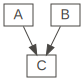

In [5]:
graphcat.notebook.display(graph)

In [6]:
import logging
logging.basicConfig(level=logging.INFO)
logger = graphcat.Logger(graph)

By default, newly-created tasks are marked as *unfinished*, because they haven't been executed yet.  Let's begin by finishing task "A" - Graphcat refers to this as *updating* the task:

INFO:graphcat:Task A executing. Inputs: {}
INFO:graphcat:Task A finished. Output: None


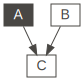

In [7]:
graph.update("A")
graphcat.notebook.display(graph)

INFO:graphcat:Task B executing. Inputs: {}
INFO:graphcat:Task B finished. Output: None
INFO:graphcat:Task C executing. Inputs: {None: [None, None]}
INFO:graphcat:Task C finished. Output: None


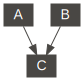

In [8]:
graph.update("C")
graphcat.notebook.display(graph)

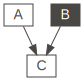

In [9]:
graph.mark_unfinished("A")
graphcat.notebook.display(graph)

Notice that both "A" and "C" have become unfinished: because "A" is unfinished and "C" depends on "A", "C" becomes unfinished too.  "B" is unaffected because it doesn't depend on "A".  Let's update "C" again:

INFO:graphcat:Task A executing. Inputs: {}
INFO:graphcat:Task A finished. Output: None
INFO:graphcat:Task C executing. Inputs: {None: [None, None]}
INFO:graphcat:Task C finished. Output: None


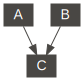

In [10]:
graph.update("C")
graphcat.notebook.display(graph)

This time "C" is executed, but only after "A".  As expected, "B" isn't executed because it was already finished.

By now, you should be convinced that Graphcat always knows which tasks to execute, and in what order.  This is true no matter how complex your computational graph.  In the next section, we will explore how to configure the graph to perform real work.

## Task Functions

In the previous section, we learned how to represent our workflow using tasks and links, but the tasks themselves didn't actually do anything when executed.  To rectify this, we will assign *task functions* that define what a task does when executed.  A task function is simply a Python function that is called when a task is executed, returning a value that is stored as the *output* for the task.  When downstream tasks are executed, their task functions have access to the outputs from their upstream dependencies.  Thus, upstream task function outputs become downstream task function *inputs*.

Let's continue with our example, by turning it into a simple calculator.  Tasks "A" and "B" will have task functions that return numbers, and task "C" will return the sum of its inputs.  First, we define the task functions for each task:

In [11]:
def task_a(name, inputs):
    return 2

def task_b(name, inputs):
    return 3

import itertools

def add(name, inputs):
    return sum(itertools.chain.from_iterable(inputs.values()))

Note that task functions must always accept two keyword arguments: `name` and `inputs`.  The `name` argument is the name of the task that is executing the task function, and is useful for logging and/or changing the function's behavior based on the task's identity.  The `inputs` argument is a Python dict containing the outputs from upstream tasks.

Now, we can assign task functions to each task in the graph:

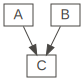

In [12]:
graph.set_task("A", task_a)
graph.set_task("B", task_b)
graph.set_task("C", add)
graphcat.notebook.display(graph)

INFO:graphcat:Task A executing. Inputs: {}
INFO:graphcat:Task A finished. Output: 2
INFO:graphcat:Task B executing. Inputs: {}
INFO:graphcat:Task B finished. Output: 3
INFO:graphcat:Task C executing. Inputs: {None: [2, 3]}
INFO:graphcat:Task C finished. Output: 5


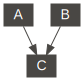

In [13]:
graph.update("C")
graphcat.notebook.display(graph)

In [14]:
print("Result:", graph.output("C"))

Result: 5


In [15]:
graph.set_task("A", graphcat.constant(4))
graph.set_task("B", graphcat.constant(5))
print("Result:", graph.output("C"))

INFO:graphcat:Task A executing. Inputs: {}
INFO:graphcat:Task A finished. Output: 4
INFO:graphcat:Task B executing. Inputs: {}
INFO:graphcat:Task B finished. Output: 5
INFO:graphcat:Task C executing. Inputs: {None: [4, 5]}
INFO:graphcat:Task C finished. Output: 9


Result: 9


In [16]:
graph.set_task("D", graphcat.constant(1.5))

which, when we connect it to "C", integrates nicely with the rest of the computation:

INFO:graphcat:Task D executing. Inputs: {}
INFO:graphcat:Task D finished. Output: 1.5
INFO:graphcat:Task C executing. Inputs: {None: [4, 5, 1.5]}
INFO:graphcat:Task C finished. Output: 10.5


Result: 10.5


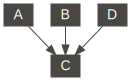

In [17]:
graph.set_links(source="D", targets="C")
print("Result:", graph.output("C"))
graphcat.notebook.display(graph)

## Named Inputs

By now, you should have questions about the way inputs are passed to task functions.  From the log message in the preceding example - `{None: [4, 5, 1.5]}` - it's obvious that the results from "A", "B", and "D" are passed to "C" using a list - `[4, 5, 1.5]`, but why is the list part of a dict, and why is the key `None`?

In [18]:
def greeting(name, inputs):
    return f"{inputs['greeting'][0]}, {inputs['subject'][0]}!"

Note that the `greeting()` task function expects the input dict to contain inputs named "greeting" and "subject".  Also note that because input dict values are always lists, the function uses `[0]` to get the first value in each list.

Now we can setup the parameter and greeting task functions for our existing graph:

In [19]:
graph.set_task("A", graphcat.constant("Hello"))
graph.set_task("B", graphcat.constant("World"))
graph.set_task("C", greeting)

And we will replace our existing links with links that connect to the named inputs required by "C"'s task function:

In [20]:
graph.set_links("A", ("C", "greeting"))
graph.set_links("B", ("C", "subject"))

... instead of passing the target name to :meth:`graphcat.Graph.set_links`, we pass a `(task name, input name)` tuple instead.  Like task names, input names don't have to be strings - they can be any hashable object.  Let's see the result:

INFO:graphcat:Task A executing. Inputs: {}
INFO:graphcat:Task A finished. Output: Hello
INFO:graphcat:Task B executing. Inputs: {}
INFO:graphcat:Task B finished. Output: World
INFO:graphcat:Task C executing. Inputs: {None: [1.5], 'greeting': ['Hello'], 'subject': ['World']}
INFO:graphcat:Task C finished. Output: Hello, World!


Result: Hello, World!


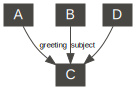

In [21]:
print("Result:", graph.output("C"))
graphcat.notebook.display(graph)

## Errors

What happens when things go wrong and your task function fails?  Let's find out, using a special Graphcat helper function for generating task functions that throw exceptions:

In [22]:
graph.set_task("D", graphcat.raise_exception(RuntimeError("Whoops!")))

(In case you're wondering, we use this for testing and debugging).

INFO:graphcat:Task D executing. Inputs: {}
ERROR:graphcat:Task D failed. Exception: Whoops!


Exception: RuntimeError('Whoops!')


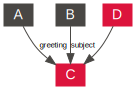

In [23]:
try:
    print("Result:", graph.output("C"))
except Exception as e:
    print(f"Exception: {e!r}")
graphcat.notebook.display(graph)

INFO:graphcat:Task D executing. Inputs: {}
ERROR:graphcat:Task D failed. Exception: Whoops!


Exception: RuntimeError('Whoops!')


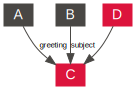

In [24]:
try:
    print("Result:", graph.output("C"))
except Exception as e:
    print(f"Exception: {e!r}")
graphcat.notebook.display(graph)

Once, the error is cleared-up, things will return to normal:

INFO:graphcat:Task D executing. Inputs: {}
INFO:graphcat:Task D finished. Output: 42
INFO:graphcat:Task C executing. Inputs: {None: [42], 'greeting': ['Hello'], 'subject': ['World']}
INFO:graphcat:Task C finished. Output: Hello, World!


Result: Hello, World!


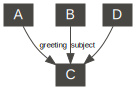

In [25]:
graph.set_task("D", graphcat.constant(42))
print("Result:", graph.output("C"))
graphcat.notebook.display(graph)